# Bike and Car Accident Exploratory Data Analysis #

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely.wkt as wkt
import math
from shapely.geometry import Point, LineString, Polygon
from matplotlib import pyplot as plt
import seaborn as sns

To Do List:

- [ ] Go back to data wrangling and compute an accident density
- [ ] Do summary statistics on bike accidents and road accidents and get the median density so we can look at outliers
- [ ] Do whisker plots too
- [ ] Redo all the correlations and bar charts based on that
- [ ] Look at which codes lead to high numbers of accidents--may need to go back into the dowloaded data to look at missing codes


In [48]:
# read in road database
rd = pd.read_csv('data/cleaned_data/road_qualities.csv').drop(columns=['Unnamed: 0'])

In [49]:
rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74122 entries, 0 to 74121
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   car_acc_score   74122 non-null  int64 
 1   bike_acc_score  74122 non-null  int64 
 2   Facility        74122 non-null  int64 
 3   F_Class         74122 non-null  int64 
 4   Urban_Area      74122 non-null  int64 
 5   Urban_Type      74122 non-null  int64 
 6   F_F_Class       74122 non-null  int64 
 7   Jurisdictn      71241 non-null  object
 8   NHS             74122 non-null  int64 
 9   Control         74122 non-null  int64 
 10  Num_Lanes       74122 non-null  int64 
 11  Opp_Lanes       74122 non-null  int64 
 12  Surface_Tp      74122 non-null  int64 
 13  Surface_Wd      74122 non-null  int64 
 14  Shldr_Rt_W      74122 non-null  int64 
 15  Shldr_Rt_T      74122 non-null  int64 
 16  Shldr_Lt_W      74122 non-null  int64 
 17  Shldr_Lt_T      74122 non-null  int64 
 18  Shldr_

In [32]:
rd.groupby(['Num_Lanes']).sum()['bike_acc_score'] / rd.groupby(['Num_Lanes']).count()['bike_acc_score']

Num_Lanes
-1    0.717738
 0    0.540192
 1    0.857710
 2    0.734390
 3    0.972251
 4    1.031003
 5    0.875000
Name: bike_acc_score, dtype: float64

,car_acc_score,bike_acc_score,AADT
car_acc_score,1.000000,0.099707,0.136556
bike_acc_score,0.099707,1.000000,0.092430
AADT,0.136556,0.092430,1.000000


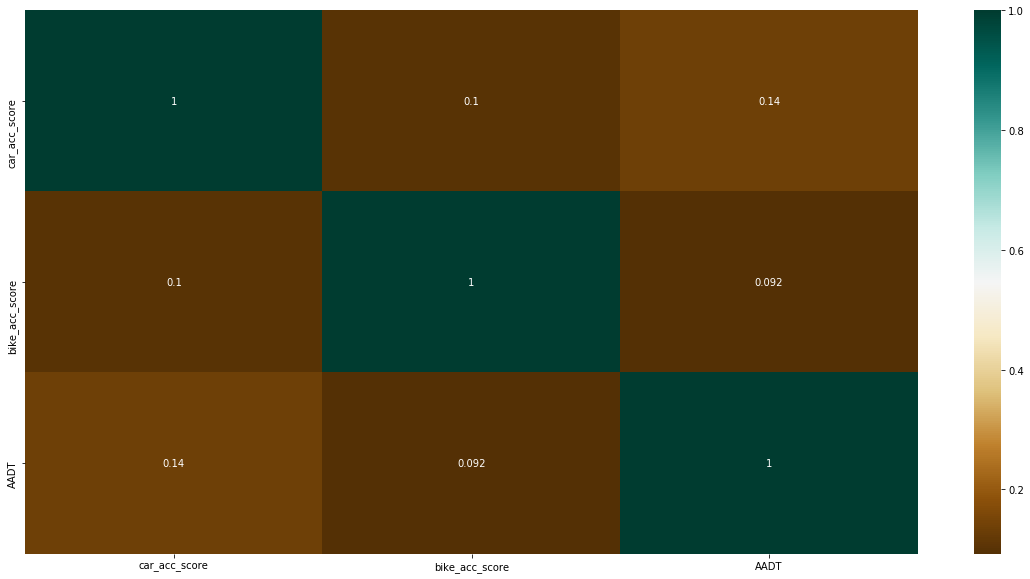

In [44]:
traf = pd.read_csv('data/cleaned_data/traffic.csv').drop(columns=['Unnamed: 0'])
plt.figure(figsize=(20,10))
c= traf.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

This does not show very strong correlation between traffic numbers and accidents. Still going to dig into this a bit more.

In [104]:
traf2 = traf.query('car_acc_score > 0 and AADT > 0')
traf2.head()

,car_acc_score,bike_acc_score,AADT
0,1,10,1154.0
1,1,4,1154.0
2,1,1,1154.0
3,1,10,3598.0
4,1,1,3598.0


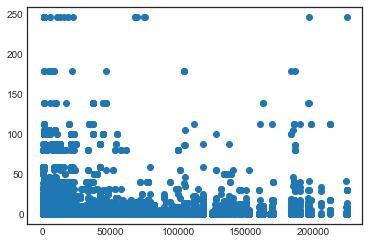

In [106]:
plt.scatter(x=traf['AADT'], y=traf['car_acc_score'])

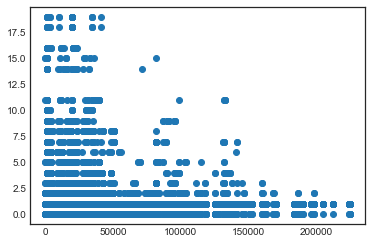

In [107]:
plt.scatter(x=traf['AADT'], y=traf['bike_acc_score'])

,car_acc_score,bike_acc_score,Num_Lanes,Surface_Wd,Med_Width,Speed_Lim
car_acc_score,1.000000,0.103873,0.014038,-0.009448,0.018558,0.075392
bike_acc_score,0.103873,1.000000,0.058120,0.047409,0.015241,0.056913
Num_Lanes,0.014038,0.058120,1.000000,0.771957,0.080369,0.219788
Surface_Wd,-0.009448,0.047409,0.771957,1.000000,0.072175,0.297778
Med_Width,0.018558,0.015241,0.080369,0.072175,1.000000,0.043334
Speed_Lim,0.075392,0.056913,0.219788,0.297778,0.043334,1.000000


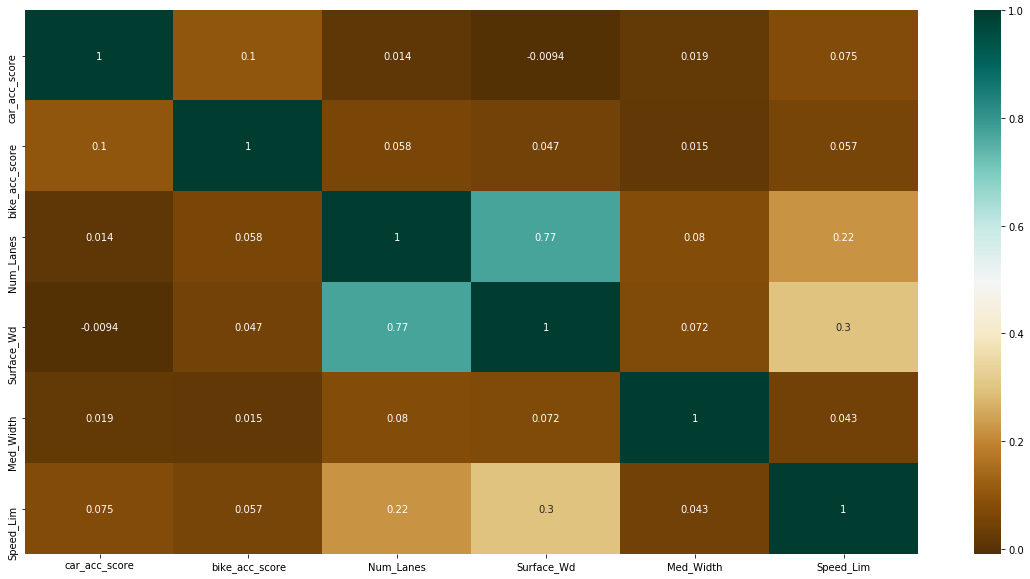

In [46]:
# run correlations on quantitative road data
q = rd[['car_acc_score', 'bike_acc_score', 'Num_Lanes', 'Surface_Wd', 'Med_Width', 'Speed_Lim']]
plt.figure(figsize=(20,10))
c= q.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

In [50]:
acc_totals = rd.groupby(['Num_Lanes']).sum()[['bike_acc_score', 'car_acc_score']]
acc_totals

,bike_acc_score,car_acc_score
Num_Lanes,,
-1,1307,6923
0,4106,10885
1,6046,30875
2,37838,79811
3,2838,12334
4,3259,15319
5,42,263


<BarContainer object of 11 artists>

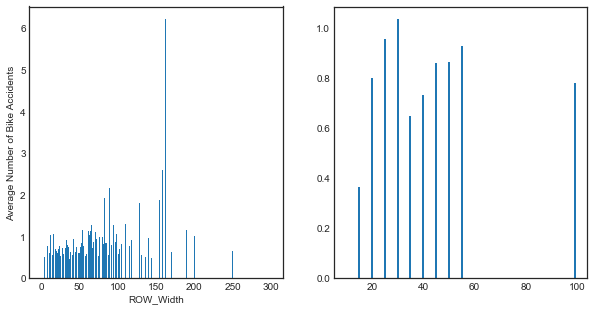

In [90]:
ROW_Width_data = rd[rd['ROW_Width'] > -1].groupby(['ROW_Width']).mean()[['bike_acc_score', 'car_acc_score']]
Speed_Lim_data = rd[rd['Speed_Lim'] > 0].groupby(['Speed_Lim']).mean()[['bike_acc_score', 'car_acc_score']]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10.0, 5.0))
fig.suptitle = ('Trying out some subplots')
axs[0].set_xlabel("ROW_Width")
axs[0].set_ylabel("Average Number of Bike Accidents")
axs[0].bar(x=ROW_Width_data.index, height=ROW_Width_data['bike_acc_score'])
axs[1].bar(x=Speed_Lim_data.index, height=Speed_Lim_data['bike_acc_score'])

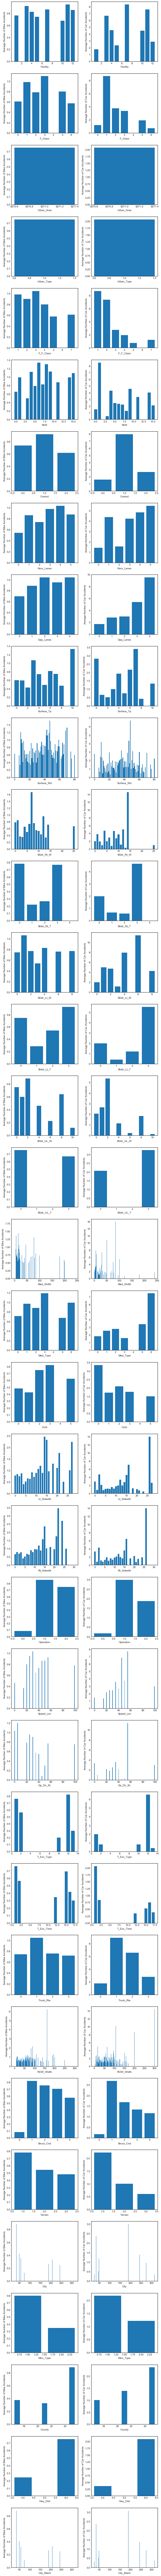

In [97]:
cols_to_plot = ['Facility', 'F_Class', 'Urban_Area', 'Urban_Type', 'F_F_Class', 'NHS', 
        'Control', 'Num_Lanes', 'Opp_Lanes', 'Surface_Tp', 'Surface_Wd', 
        'Shldr_Rt_W', 'Shldr_Rt_T', 'Shldr_Lt_W', 'Shldr_Lt_T', 'Shldr_UL_W', 
        'Shldr_UL_T', 'Med_Width', 'Med_Type', 'Curb', 'Lt_Sidewlk', 'Rt_Sidewlk', 
        'Operation', 'Speed_Lim', 'Op_Dir_SL', 'T_Exc_Type', 'T_Exc_Time', 'Truck_Rte', 
        'ROW_Width', 'Struct_Cnd', 'Terrain', 'City', 'Mun_Type', 'County', 'Hwy_Dist', 
        'City_Maint']
#plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=len(cols_to_plot), ncols=2, figsize=(10.0, 5.0 * len(cols_to_plot)))

for index, col in enumerate(cols_to_plot):
    prevalence = rd[rd[col] > -1].groupby([col]).mean()[['bike_acc_score', 'car_acc_score']]
    axs[index][0].set_xlabel(col)
    axs[index][1].set_xlabel(col)
    axs[index][0].set_ylabel("Average Number of Bike Accidents")
    axs[index][1].set_ylabel("Average Number of Car Accidents")
    axs[index][0].bar(x=prevalence.index, height=prevalence['bike_acc_score'])
    axs[index][1].bar(x=prevalence.index, height=prevalence['car_acc_score'])
    



In [112]:
rd.query('T_Exc_Time == 2')[['bike_acc_score', 'car_acc_score']]

,bike_acc_score,car_acc_score
13,10,1
14,4,1
74,10,1
964,4,1
965,3,4
...,...,...
73963,0,0
73967,0,0
73977,0,0
74092,0,0
